# **PROFILAK ETA EMITANTZIAK LORTZEKO KODEA**

In [1]:
import numpy as np 

def emittance_rms(q,p):
    q = np.array(q)
    p = np.array(p)

    mean_q = np.mean(q)
    mean_p = np.mean(p)

    var_qq = np.mean((q-mean_q)**2)
    var_pp = np.mean((p-mean_p)**2)
    var_qp = np.mean((q-mean_q)*(p-mean_p))

    emittance = np.sqrt(var_qq * var_pp - var_qp**2)

    return emittance

## X-ARDATZEKO PROFILERAKO PARTIKULEN ESTATISTIKAK LORTU

In [46]:
import pandas as pd
import re
import os

target_x = 288
tolerance = 1
archive = '../stats.txt'
csv_filename = f"stats_x{target_x}mm.csv"

if os.path.exists(csv_filename):
    print(f"'{csv_filename}' artxiboa aurkituta. Datuak kargatzen...")
    df_results = pd.read_csv(csv_filename)

else:
    # Datuak irakurri
    with open(archive, 'r', encoding='utf-8') as f:
        rows = f.readlines()
    
    headers = [col.strip() for col in rows[7].strip().split(',')]
    data = pd.read_csv(archive, skiprows=8, names=headers)
    
    # Lortu qx, qy, qz, py, pz eta mp-rentzako zutabe guztiak
    qx_cols = [col for col in data.columns if col.startswith("qx")]
    qy_cols = [col for col in data.columns if col.startswith("qy")]
    qz_cols = [col for col in data.columns if col.startswith("qz")]
    py_cols = [col for col in data.columns if col.startswith("cpt.ppy")]
    pz_cols = [col for col in data.columns if col.startswith("cpt.ppz")]
    mp_cols = [col for col in data.columns if col.startswith("cpt.mp")]
    
    # Zutabeetatik denbora lortu, zutabeak hiztegietan mapeatzeko
    def get_time(col):
        return col.split("t=")[-1]
    
    time_to_qx = {get_time(col): col for col in qx_cols}
    time_to_qy = {get_time(col): col for col in qy_cols}
    time_to_qz = {get_time(col): col for col in qz_cols}
    time_to_py = {get_time(col): col for col in py_cols}
    time_to_pz = {get_time(col): col for col in pz_cols}
    time_to_mp = {get_time(col): col for col in mp_cols}
    
    # Emaitzak gordetzeko lista
    results = []
    
    # Partikula bakoitzarentzat iteratu
    for idx, row in data.iterrows():
        found = False
        for t in sorted(time_to_qx, key=lambda x: float(x)):
            # Lortu qx-ren balioa denbora bakoitzerako
            qx_val = row[time_to_qx[t]]
            if target_x - tolerance <= qx_val <= target_x + tolerance:
                # qx-ren balioa nahi dugun profila bada, beste estatistika gutziak gorde denboraren arabera
                qy_val = row[time_to_qy[t]]
                qz_val = row[time_to_qz[t]]
                py_val = row[time_to_py[t]]
                pz_val = row[time_to_pz[t]]
                mp_val = row[time_to_mp[t]]
                results.append({
                    "particle": idx,
                    "time": float(t),
                    "qx": qx_val,
                    "qy": qy_val,
                    "qz": qz_val,
                    "py": py_val,
                    "pz": pz_val,
                    "mp": mp_val
                })
                found = True
                break  # Partikula bakoitzarentzat soilik behin lortu profilaren datuak (tolerantzia kontuan hartuta, profila ez da guztiz zehatza)
        if not found:
            continue  # Profiletik igarotzen ez bada, hurrengo denbora pausura igaro
    
    # Emaitzak DataFrame-era bihurtu
    df_results = pd.DataFrame(results)
    
# Erakutsi zenbat partikula igaro diren profiletik
print(f"x={target_x} ± {tolerance} mm planoa igaro duten partikulak: {len(df_results)}")
print(df_results.head())
# Azkenik, DataFrame-a csv motako artxibora bihurtu
df_results.to_csv(f"stats_x{target_x}mm.csv", index=False)


x=288 ± 1 mm planoa igaro duten partikulak: 459
   particle    time          qx        qy        qz        py        pz  \
0        38  156.42  287.901700  0.023470 -0.440564 -0.000799 -0.000593   
1        76  156.42  287.862603 -0.101700  0.195036 -0.001405  0.000459   
2        94  156.42  287.887537 -0.078462  0.205626 -0.001469  0.000375   
3       107  156.42  287.422885 -0.089187  0.134817  0.001848  0.000587   
4       148  156.42  287.152104  0.136502 -0.081937  0.004555  0.000248   

             mp  
0  1.672622e-27  
1  1.672622e-27  
2  1.672622e-27  
3  1.672622e-27  
4  1.672622e-27  


## PROFILAK ETA FASE-ESPAZIOAK IRUDIKATU, EMITANTZIAK LORTU (partikula guztiak)

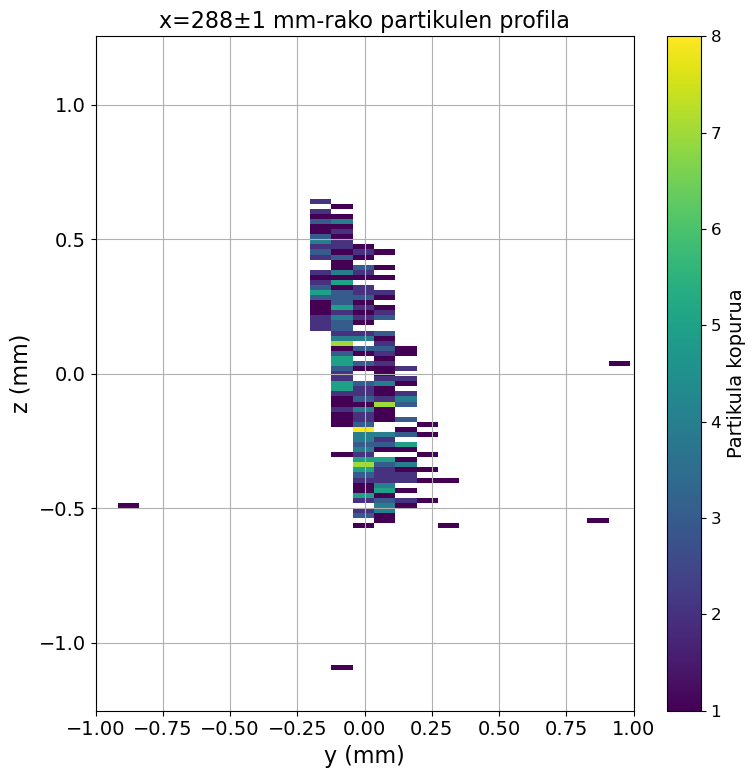

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.hist2d(df_results['qy'], df_results['qz'], bins=100, cmap='viridis', cmin=1)
cbar = plt.colorbar()
cbar.set_label('Partikula kopurua', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.title(f"x={target_x}±{tolerance} mm-rako partikulen profila", fontsize=16)
plt.xlabel("y (mm)")
plt.ylabel("z (mm)")
plt.grid(True)
plt.axis('equal')
plt.xlim(-1,1)
plt.ylim(-1,1)


plt.rcParams.update({
    'font.size': 14,           
    'axes.titlesize': 16,      
    'axes.labelsize': 16,        
    'xtick.labelsize': 14,      
    'ytick.labelsize': 14,         
})

plt.savefig("../Figures/lebt_profile.png", dpi=300)
plt.tight_layout()
plt.show()

In [22]:
print(max(df_results['qy']))

6.2026314320604365


In [44]:
y_emittance = emittance_rms(df_results['qy'], df_results['py'])
z_emittance = emittance_rms(df_results['qz'], df_results['pz'])

print("Emitantzia-y:", y_emittance, " (mm rad)")
print("Emitantzia-z:", z_emittance, " (mm rad)")

Emitantzia-y: 0.0016729910258585317  (mm rad)
Emitantzia-z: 0.0004911575455859032  (mm rad)


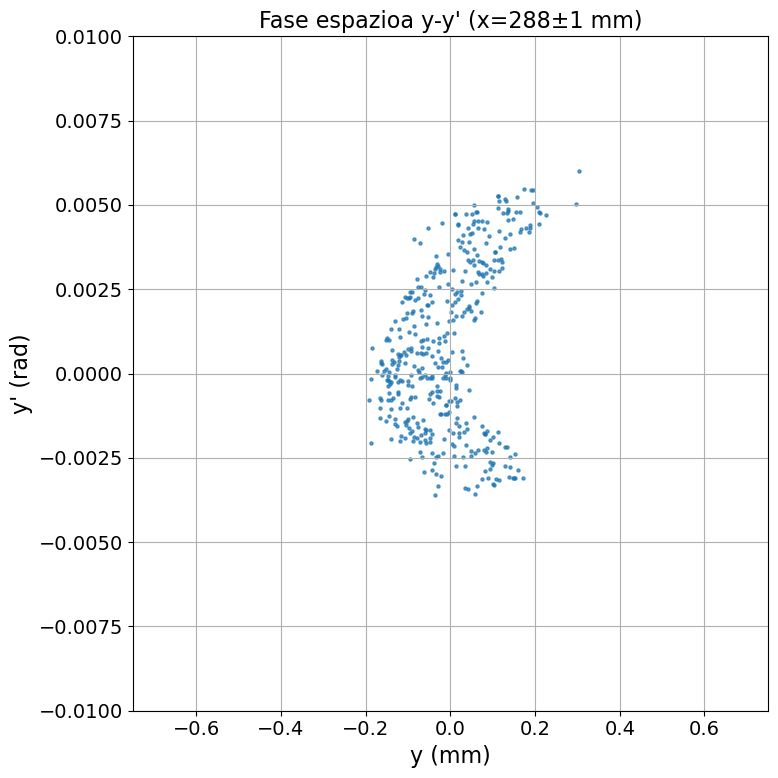

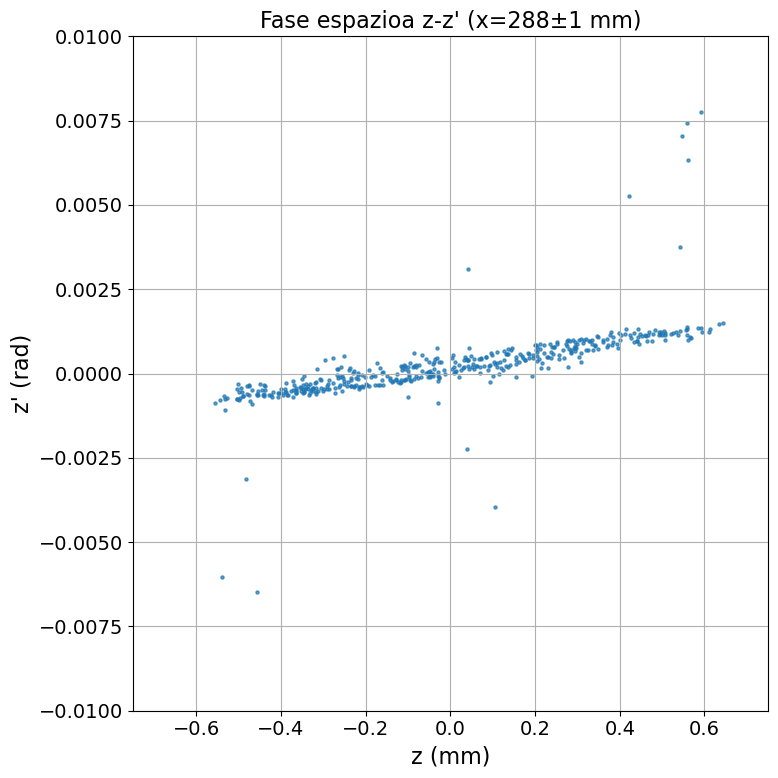

In [50]:
plt.figure(figsize=(8, 8))
plt.scatter(df_results['qy'], df_results['py'], s=5, alpha=0.7)

plt.rcParams.update({
    'font.size': 14,           
    'axes.titlesize': 16,      
    'axes.labelsize': 16,        
    'xtick.labelsize': 14,      
    'ytick.labelsize': 14,         
})

plt.title(f"Fase espazioa y-y' (x={target_x}±{tolerance} mm)")
plt.xlabel("y (mm)")
plt.ylabel("y' (rad)")
plt.grid(True)
plt.xlim(-0.75,0.75)
plt.ylim(-0.01,0.01)

plt.tight_layout()
plt.savefig("../Figures/lebt_emitantzia_y.png", dpi=300)
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(df_results['qz'], df_results['pz'], s=5, alpha=0.7)

plt.title(f"Fase espazioa z-z' (x={target_x}±{tolerance} mm)")
plt.xlabel("z (mm)")
plt.ylabel("z' (rad)")
plt.grid(True)
plt.xlim(-0.75,0.75)
plt.ylim(-0.01,0.01)

plt.tight_layout()
plt.savefig("../Figures/lebt_emitantzia_z.png", dpi=300)
plt.show()

## PROFILAK ETA FASE-ESPAZIOAK IRUDIKATU, EMITANTZIAK LORTU (partikuletan banatuta)

In [9]:
df_proton = df_results[np.isclose(df_results["mp"], 1.67262190E-27, atol=1e-30)]
df_dihydrogen = df_results[np.isclose(df_results["mp"], 3.34524380E-27, atol=1e-30)]
df_trihydrogen = df_results[np.isclose(df_results["mp"], 5.01786569E-27, atol=1e-30)]

In [10]:
y_emittance = emittance_rms(df_proton['qy'], df_proton['py'])
z_emittance = emittance_rms(df_proton['qz'], df_proton['pz'])

print("Protoien emitantzia-y:", y_emittance, " (mm rad)")
print("Protoien emitantzia-z:", z_emittance, " (mm rad)")

Protoien emitantzia-y: 0.002464269047413633  (mm rad)
Protoien emitantzia-z: 0.0026594244827541137  (mm rad)


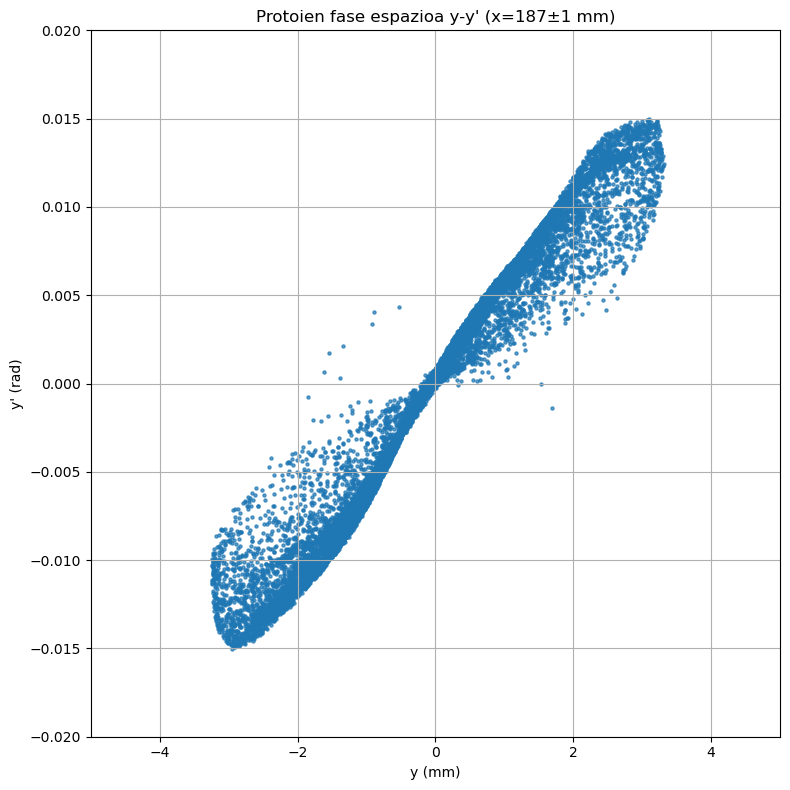

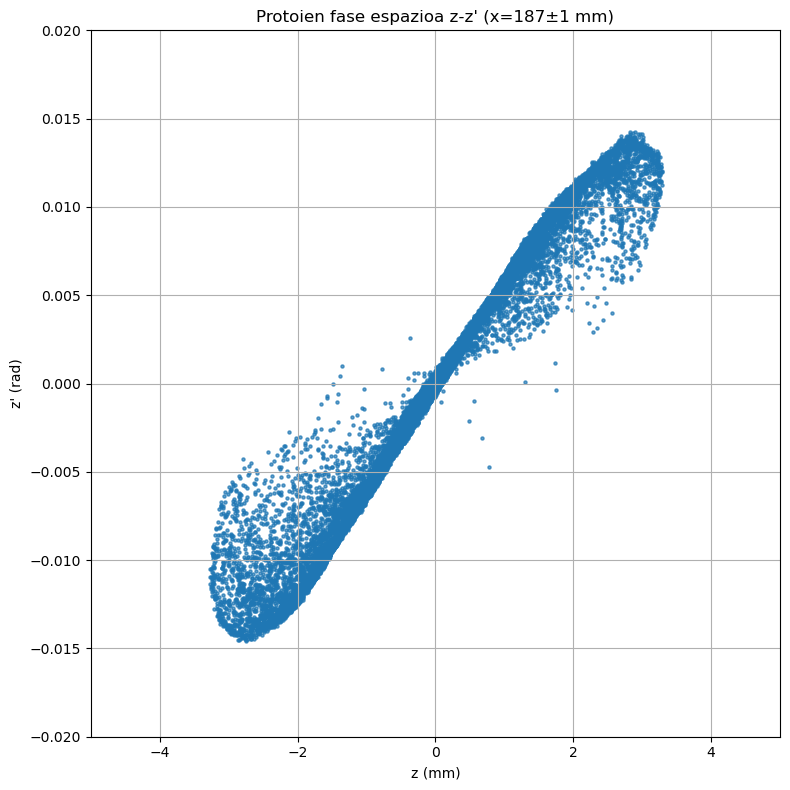

In [37]:
plt.figure(figsize=(8, 8))
plt.scatter(df_proton['qy'], df_proton['py'], s=5, alpha=0.7)

plt.title(f"Protoien fase espazioa y-y' (x={target_x}±{tolerance} mm)")
plt.xlabel("y (mm)")
plt.ylabel("y' (rad)")
plt.grid(True)
plt.xlim(-5,5)
plt.ylim(-0.02,0.02)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(df_proton['qz'], df_proton['pz'], s=5, alpha=0.7)

plt.title(f"Protoien fase espazioa z-z' (x={target_x}±{tolerance} mm)")
plt.xlabel("z (mm)")
plt.ylabel("z' (rad)")
plt.grid(True)
plt.xlim(-5,5)
plt.ylim(-0.02,0.02)

plt.tight_layout()
plt.show()

In [38]:
y_emittance = emittance_rms(df_dihydrogen['qy'], df_dihydrogen['py'])
z_emittance = emittance_rms(df_dihydrogen['qz'], df_dihydrogen['pz'])

print("Dihidrogenoaren emitantzia-y:", y_emittance, " (mm rad)")
print("Dihidrogenoaren emitantzia-z:", z_emittance, " (mm rad)")

Dihidrogenoaren emitantzia-y: 0.00255241468377306  (mm rad)
Dihidrogenoaren emitantzia-z: 0.0026972165039638677  (mm rad)


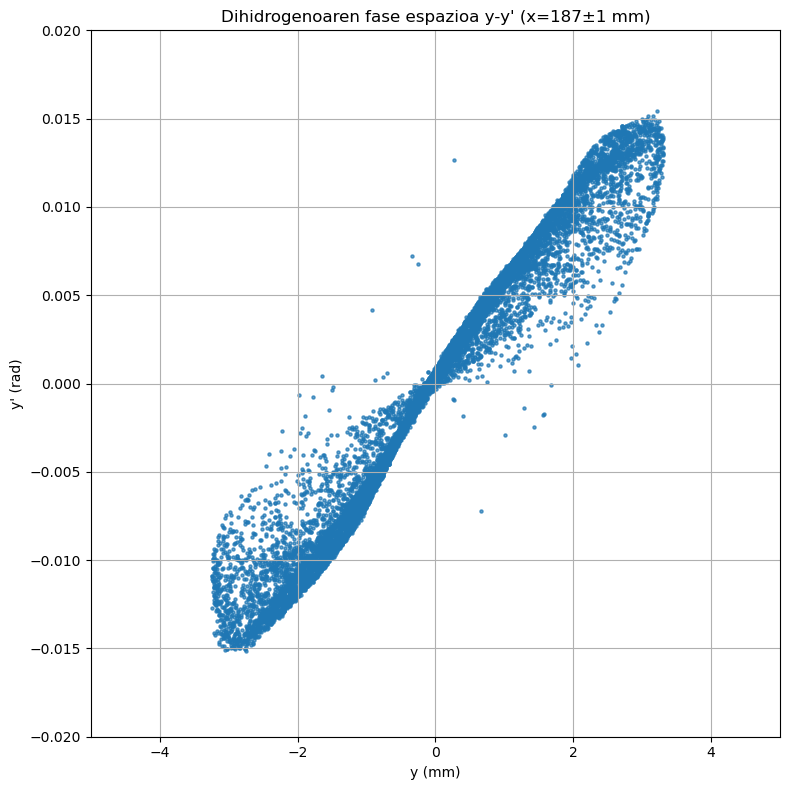

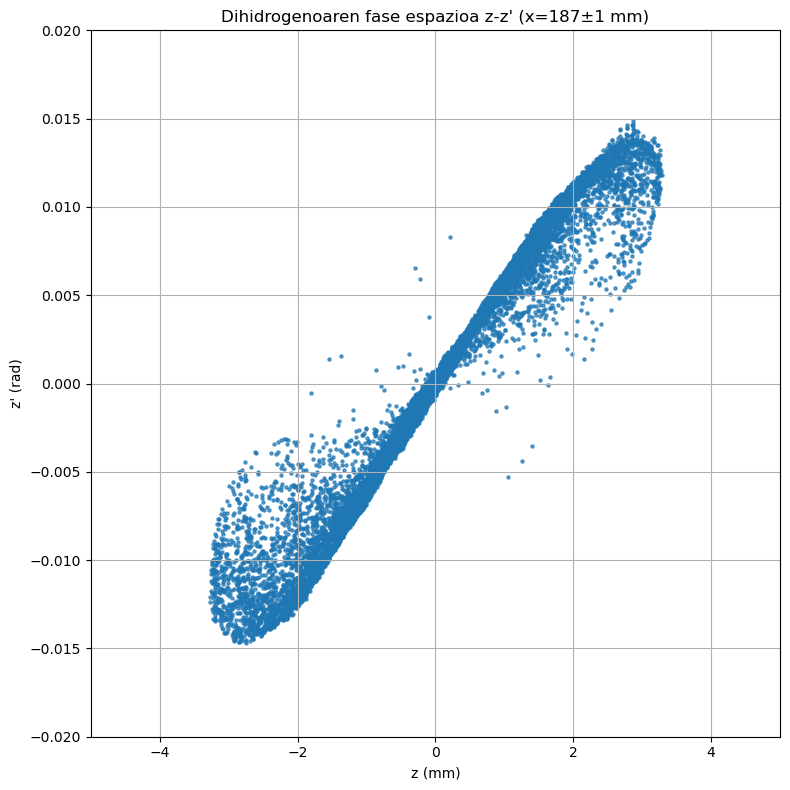

In [40]:
plt.figure(figsize=(8, 8))
plt.scatter(df_dihydrogen['qy'], df_dihydrogen['py'], s=5, alpha=0.7)

plt.title(f"Dihidrogenoaren fase espazioa y-y' (x={target_x}±{tolerance} mm)")
plt.xlabel("y (mm)")
plt.ylabel("y' (rad)")
plt.grid(True)
plt.xlim(-5,5)
plt.ylim(-0.02,0.02)


plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(df_dihydrogen['qz'], df_dihydrogen['pz'], s=5, alpha=0.7)

plt.title(f"Dihidrogenoaren fase espazioa z-z' (x={target_x}±{tolerance} mm)")
plt.xlabel("z (mm)")
plt.ylabel("z' (rad)")
plt.grid(True)
plt.xlim(-5,5)
plt.ylim(-0.02,0.02)

plt.tight_layout()
plt.show()

In [15]:
y_emittance = emittance_rms(df_trihydrogen['qy'], df_trihydrogen['py'])
z_emittance = emittance_rms(df_trihydrogen['qz'], df_trihydrogen['pz'])

print("Trihidrogenoaren emitantzia-y:", y_emittance, " (mm rad)")
print("Trihidrogenoaren emitantzia-z:", z_emittance, " (mm rad)")

Trihidrogenoaren emitantzia-y: 0.0025249353035073094  (mm rad)
Trihidrogenoaren emitantzia-z: 0.002611312062401852  (mm rad)


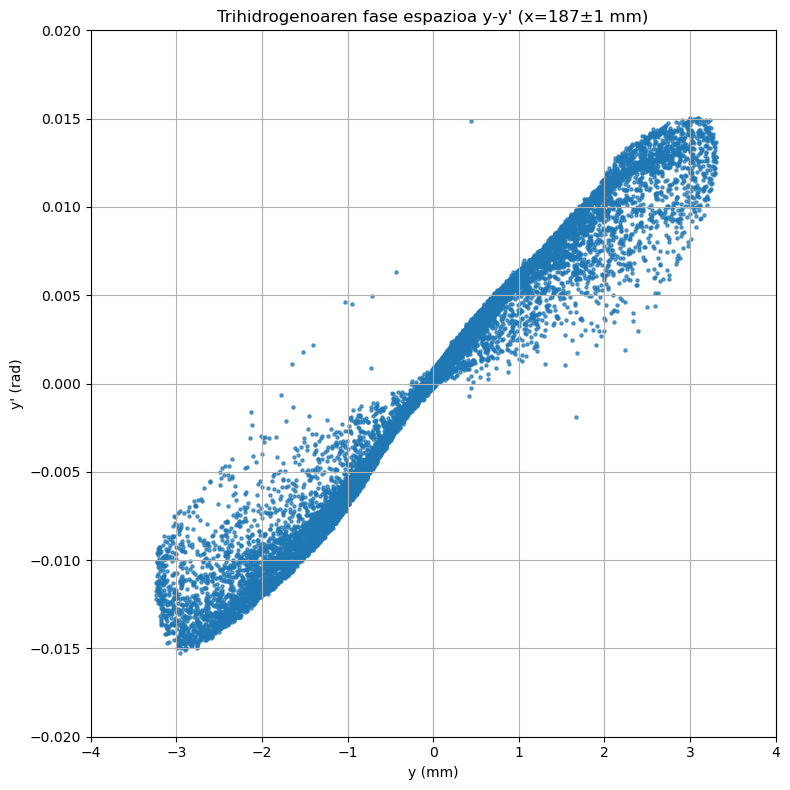

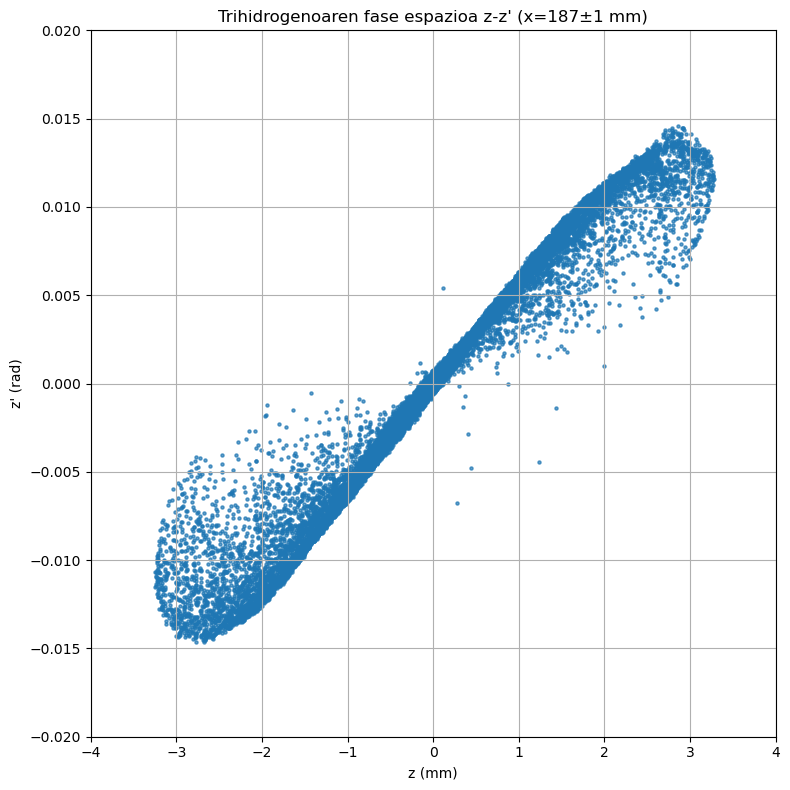

In [42]:
plt.figure(figsize=(8, 8))
plt.scatter(df_trihydrogen['qy'], df_trihydrogen['py'], s=5, alpha=0.7)

plt.title(f"Trihidrogenoaren fase espazioa y-y' (x={target_x}±{tolerance} mm)")
plt.xlabel("y (mm)")
plt.ylabel("y' (rad)")
plt.grid(True)
plt.xlim(-4,4)
plt.ylim(-0.02,0.02)

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(df_trihydrogen['qz'], df_trihydrogen['pz'], s=5, alpha=0.7)

plt.title(f"Trihidrogenoaren fase espazioa z-z' (x={target_x}±{tolerance} mm)")
plt.xlabel("z (mm)")
plt.ylabel("z' (rad)")
plt.grid(True)
plt.xlim(-4,4)
plt.ylim(-0.02,0.02)

plt.tight_layout()
plt.show()